In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models

import os

from PIL import Image

In [3]:
root = os.getcwd() + '/root'
images_folder = root + '/images'
train_dir = root + '/train'
test_dir = root + '/test'

### Load the data and transform

In [4]:
train_tfms = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        ])

val_tfms = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        ])
image_datasets = {
    'train': torchvision.datasets.ImageFolder(train_dir, transform=train_tfms),
    'validation': torchvision.datasets.ImageFolder(test_dir, transform=val_tfms)
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, drop_last=True, num_workers=0),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle=True, drop_last=True, num_workers=0)
}

### Setting up GPU

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
GeForce GTX 1060 with Max-Q Design


### Getting pre-trained weights and fix the model

In [5]:
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
                nn.Linear(2048,128),
                nn.ReLU(inplace=True),
                nn.Linear(128,37)).to(device)

In [6]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

### Train the model

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return model

In [9]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 1.5269, acc: 0.6317
validation loss: 0.5414, acc: 0.8557
Epoch 2/10
----------
train loss: 0.4785, acc: 0.8579
validation loss: 0.3971, acc: 0.8720
Epoch 3/10
----------
train loss: 0.3847, acc: 0.8770
validation loss: 0.3369, acc: 0.8850
Epoch 4/10
----------
train loss: 0.3387, acc: 0.8850
validation loss: 0.3174, acc: 0.8855
Epoch 5/10
----------
train loss: 0.3134, acc: 0.8931
validation loss: 0.3279, acc: 0.8823
Epoch 6/10
----------
train loss: 0.3081, acc: 0.8973
validation loss: 0.3187, acc: 0.8886
Epoch 7/10
----------
train loss: 0.2805, acc: 0.8991
validation loss: 0.3065, acc: 0.8882
Epoch 8/10
----------
train loss: 0.2562, acc: 0.9082
validation loss: 0.2982, acc: 0.8950
Epoch 9/10
----------
train loss: 0.2484, acc: 0.9138
validation loss: 0.3087, acc: 0.8895
Epoch 10/10
----------
train loss: 0.2178, acc: 0.9219
validation loss: 0.3360, acc: 0.8774


### Save and Load

In [10]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [11]:
torch.save(model_trained.state_dict(), 'models/weights_resnet50.h5')

In [6]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 37)).to(device)
model.load_state_dict(torch.load('models/weights_resnet50.h5'))

<All keys matched successfully>

### Make predictions

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloaders['validation']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2218 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 2218 test images: 87.681159 %


In [8]:
nb_classes = 37

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [15]:
confusion_matrix.shape

torch.Size([37, 37])

In [9]:
cm = confusion_matrix.numpy()
precision, recall = 0, 0
sum_row = np.sum(cm, axis=0)
sum_col = np.sum(cm, axis=1)
for i in range(37):
    precision = precision + cm[i][i] / sum_col[i]
    recall = recall + cm[i][i] / sum_row[i]
precision = precision / 37
recall = recall / 37

In [10]:
precision

0.8723436867868578

In [11]:
recall

0.884125026496681

In [12]:
f1 = 2 * precision * recall / (precision + recall)
f1

0.8781948455578803

<AxesSubplot:>

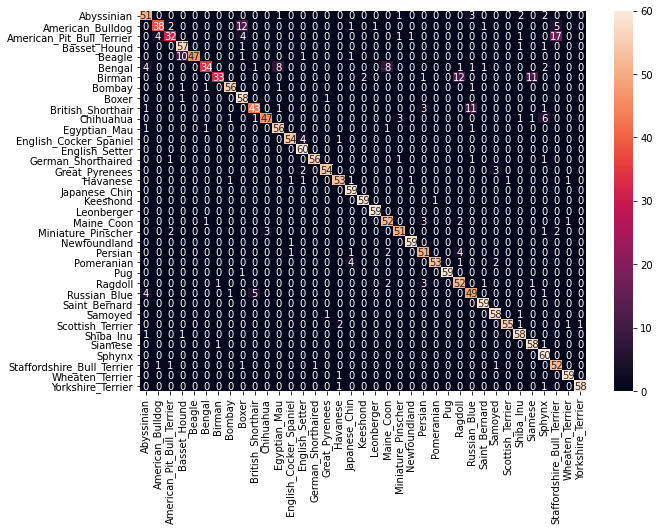

In [16]:
classes = image_datasets['train'].classes
df_cm = pd.DataFrame(confusion_matrix.numpy(), index=[i for i in classes],
                    columns=[i for i in classes])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)

### Test with random image

In [21]:
test_img_folder = os.getcwd() + '/random_test_images'

In [22]:
test_img_paths = os.listdir(test_img_folder)
test_img_paths

['persian_1.jpg', 'shiba_inu_1.jpeg', 'samoyed_1.jpeg', 'sphnyx_1.jpg']

In [23]:
test_img_list = [Image.open(test_img_folder + '/' + img_path) for img_path in test_img_paths]
validation_batch = torch.stack([val_tfms(img).to(device) for img in test_img_list])
prediction_tensor = model(validation_batch)
prediction_probs = nn.functional.softmax(prediction_tensor, dim=1).cpu().data.numpy()
prediction_res = np.argmax(prediction_probs, axis=1)

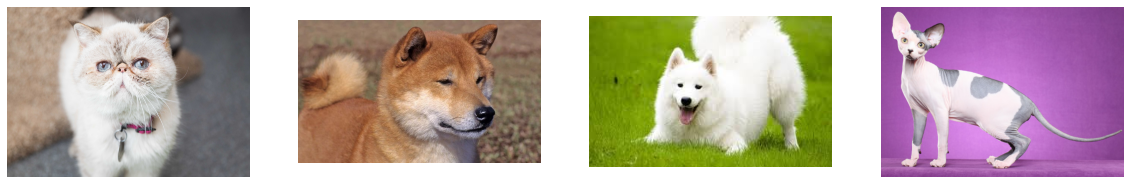

In [24]:
fig, axs = plt.subplots(1, len(test_img_list), figsize=(20, 5))
for i, img in enumerate(test_img_list):
    ax = axs[i]
    ax.axis('off')
    ax.imshow(img)

In [25]:
print(' / '.join('%5s' % classes[i] for i in prediction_res))

Persian / Shiba_Inu / Samoyed / Sphynx
